In [1]:
from __future__ import print_function
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import PReLU as PRELU
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf

results_transit = np.load('results_transit_100ppm_3000it_7d_1.5R.npy', allow_pickle = True)#[0:1000]
#results_transit = np.load('results_transit_100ppm_1000it_rand_period_1.25R.npy', allow_pickle = True)

results_noise = np.load('results100ppm_3000it.npy', allow_pickle = True)[0:2500]

test


In [2]:
width = 100

In [3]:
transits = np.zeros((len(results_transit), width,1))
y_t = np.zeros(len(results_transit))
for i, result in enumerate(results_transit):
    
    phase = result.folded_phase
    center = np.abs(phase-.5).argmin()
    start = center - int(width/2)
    end = center + int(width/2)
    index = np.arange(start,end)
    if (i==40):
        t = result.folded_phase[index]
    if (7*(1-0.05)< result.period < 7*(1+0.05)):
        y_t[i] = int(1)
    else:
        y_t[i] = int(0)
    for j, ind in enumerate(index):
        transits[i][j] = (result.folded_y[ind] -1) * 1
    
noise = np.zeros((len(results_noise), width, 1))
y_n = np.zeros(len(results_noise))
for i, result in enumerate(results_noise):
    
    phase = result.folded_phase
    center = np.abs(phase-.5).argmin()
    start = center - int(width/2)
    end = center + int(width/2)
    index = np.arange(start,end)
    if (i==40):
        n = result.folded_phase[index]
    y_n[i] = int(0)
    for j, ind in enumerate(index):
        noise[i][j] = result.folded_y[ind] -1

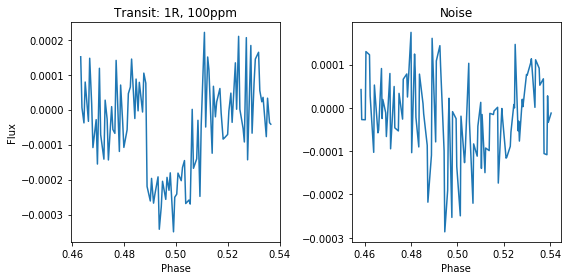

In [4]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(t, transits[40])
ax[0].set_xlabel('Phase')
ax[0].set_ylabel('Flux')
ax[0].set_title('Transit: 1R, 100ppm')
ax[1].plot(n, noise[40])
ax[1].set_xlabel('Phase')
ax[1].set_title('Noise')
plt.tight_layout()

In [5]:
#create output array
"""y_t = np.load('results_transit_100ppm_1000it_rand_period_1.15R_y.npy', allow_pickle = True)
y = np.zeros(len(results_transit) + len(results_noise))
y[0:len(results_noise)] = int(0)
y[len(results_noise):len(y)] = int(1)#y_t
y = y.astype(int)"""

"y_t = np.load('results_transit_100ppm_1000it_rand_period_1.15R_y.npy', allow_pickle = True)\ny = np.zeros(len(results_transit) + len(results_noise))\ny[0:len(results_noise)] = int(0)\ny[len(results_noise):len(y)] = int(1)#y_t\ny = y.astype(int)"

In [6]:
x = np.concatenate((noise,transits))
y = np.concatenate((y_n,y_t))
y = y.astype(int)

In [7]:
#Shuffle x and y arrays together
indices = np.arange(x.shape[0])
np.random.shuffle(indices)

x = x[indices]
y = y[indices]

In [8]:
#split up training and validation sets
x_train = x[0:int(.8*len(x))]
y_train = y[0:int(.8*len(y))]
x_test = x[int(.8*len(x)): len(x)]
y_test = y[int(.8*len(y)): len(y)]

In [27]:
from tensorflow.keras import metrics
threshold = 0.5
#Exonet
def exo_cnn(maxlen):
    model = Sequential()
    model.add(Conv1D(kernel_size=5, filters=16,
                            activation=PRELU(),
                            input_shape=(maxlen,1),
                            #strides=1, # same as subsample_length?
                            name='conv1',
                            padding="valid"))
    model.add(Conv1D(kernel_size=5, filters=16,
                            activation=PRELU(),
                            input_shape=(maxlen,1),
                            #strides=1, # same as subsample_length?
                            name='conv2',
                            padding="valid"))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(kernel_size=5, filters=32,
                            activation=PRELU(),
                            input_shape=(maxlen,1),
                            #strides=1, # same as subsample_length?
                            name='conv3',
                            padding="valid"))
    model.add(Conv1D(kernel_size=5, filters=32,
                            activation=PRELU(),
                            input_shape=(maxlen,1),
                            #strides=1, # same as subsample_length?
                            name='conv4',
                            padding="valid"))
    model.add(MaxPooling1D(3))
    model.add(Flatten())

    model.add(Dense(512))
    model.add(PRELU())
    model.add(Dense(512))
    model.add(PRELU())
    model.add(Dense(512))
    model.add(PRELU())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()
    SGDsolver = SGD(lr=0.1, momentum=0.25, decay=0.0001, nesterov=True)

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics = [metrics.BinaryAccuracy(name='acc', threshold = 0.5)])
    return model

def weighted_binary_crossentropy(y_true, y_pred):

        # Calculate the binary crossentropy
        b_ce = BinaryCrossentropy()(y_true, y_pred)

        scale = .5
        zero_weight = 1#1/scale
        one_weight = 1#(scale-1)/scale
        
        #y_true = y_true.eval(session=tf.compat.v1.Session())
        #y_pred = y_pred.eval(session=tf.compat.v1.Session())
        
        #tf.make_ndarray(y_true)
        
        #weight = np.ones(y_true.shape)
        """for i in range(len(y_true.shape)):
            y_t = y_true[i].value
            y_p = y_pred[i].value
            #True Positive
            if (y_t == 1 and y_p > threshold):
                weight[i] = 1
            #False Negative
            if (y_true[i] == 1 and y_pred[i] < threshold):
                weight[i] = 1
            #False Positive
            if (y_true[i] == 0 and y_pred[i] > threshold):
                weight[i] = 5
            #True Negative
            if (y_true[i] == 0 and y_pred[i] < threshold):
                weight[i] = 1"""
            
            
        # Apply the weights
        #weighted_b_ce = weight * b_ce
        tf.round(y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight * (scale*(tf.round(y_pred))+1)
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)


#Network found from a github repo
def make_cnn(maxlen):

    pool_length = 3

    model = Sequential()
    model.add(Conv1D(kernel_size=5, filters=16,
                            activation=PRELU(),
                            input_shape=(maxlen,1),
                            #strides=1, # same as subsample_length?
                            name='conv1',
                            padding="valid"))
    model.add(AveragePooling1D(pool_size=pool_length))


    model.add(Conv1D(kernel_size=5, filters=8,
                            activation=PRELU(),
                            input_shape=(maxlen,1),
                            #strides=1, # same as subsample_length?
                            name='conv2',
                            padding="valid"))
    model.add(AveragePooling1D(pool_size=pool_length))
    
    """model.add(Conv1D(kernel_size=5, filters=8,
                            activation=PRELU(),
                            input_shape=(maxlen,1),
                            #strides=1, # same as subsample_length?
                            name='conv3',
                            padding="valid"))
    model.add(AveragePooling1D(pool_size=pool_length))"""

    # conv2
    #model.add(Convolution1D(nb_filter=4,
    #                        filter_length=filter_length,
    #                        border_mode='valid',
    #                        activation='linear',
    #                        subsample_length=1,
    #                        name='conv2'))
    #model.add(AveragePooling1D(pool_length=pool_length))
    model.add(Flatten())

    model.add(Dense(64, kernel_initializer='he_normal',bias_initializer='zeros'))
    model.add(PRELU())
    #model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32, kernel_initializer='he_normal',bias_initializer='zeros'))
    model.add(PRELU())
    #model.add(Activation('relu'))

    model.add(Dense(8, kernel_initializer='he_normal',bias_initializer='zeros'))
    model.add(PRELU())
    #model.add(Activation('relu'))

    model.add(Dense(1))

    model.add(Activation('sigmoid'))

    model.summary()
    SGDsolver = SGD(lr=0.1, momentum=0.25, decay=0.0001, nesterov=True)

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics = [metrics.BinaryAccuracy(name='acc', threshold = 0.5)])
    #weighted_binary_crossentropy
    return model




In [28]:
model = make_cnn(width)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 96, 16)            1632      
_________________________________________________________________
average_pooling1d_2 (Average (None, 32, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 28, 8)             872       
_________________________________________________________________
average_pooling1d_3 (Average (None, 9, 8)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4672      
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 64)               

In [29]:
history = model.fit(x=x_train, y=y_train,
          validation_data=(x_test, y_test),
          batch_size=16,
          epochs=50,
          callbacks=[])

Epoch 1/50
275/275 [==============================] - 4s 13ms/step - loss: 0.6903 - acc: 0.5425 - val_loss: 0.6890 - val_acc: 0.5509
Epoch 2/50
275/275 [==============================] - 3s 11ms/step - loss: 0.6898 - acc: 0.5441 - val_loss: 0.6888 - val_acc: 0.5509
Epoch 3/50
275/275 [==============================] - 3s 11ms/step - loss: 0.6898 - acc: 0.5441 - val_loss: 0.6880 - val_acc: 0.5509
Epoch 4/50
275/275 [==============================] - 3s 11ms/step - loss: 0.6899 - acc: 0.5441 - val_loss: 0.6880 - val_acc: 0.5509
Epoch 5/50
275/275 [==============================] - 3s 11ms/step - loss: 0.6898 - acc: 0.5441 - val_loss: 0.6880 - val_acc: 0.5509
Epoch 6/50
275/275 [==============================] - 3s 11ms/step - loss: 0.6900 - acc: 0.5443 - val_loss: 0.6882 - val_acc: 0.5509
Epoch 7/50
275/275 [==============================] - 3s 11ms/step - loss: 0.6897 - acc: 0.5441 - val_loss: 0.6887 - val_acc: 0.5509
Epoch 8/50
275/275 [==============================] - 3s 11ms/step - 

Text(0.5, 1.0, 'Unweighted Loss: Output Probabilities')

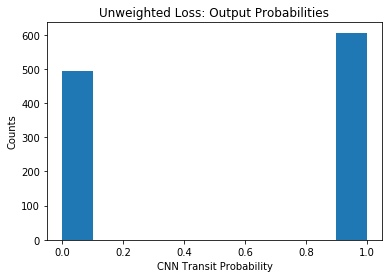

In [32]:
prob = model.predict(x_test)[:,0]
bins = np.arange(0,1.1,0.1)
plt.hist(prob, bins= bins)
plt.ylabel("Counts")
plt.xlabel('CNN Transit Probability')
plt.title("Unweighted Loss: Output Probabilities")

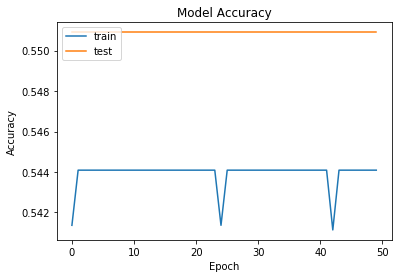

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(0.5, 0, 'Epoch')

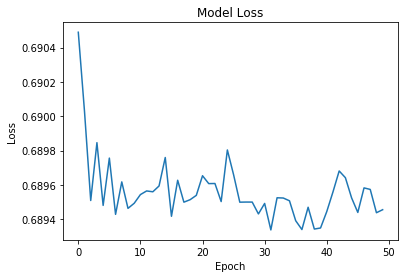

In [14]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 1.0, 'ROC curve')

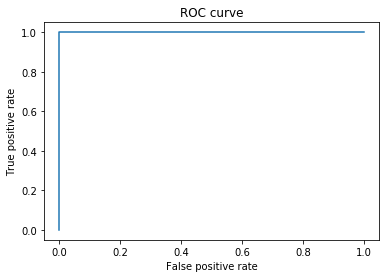

In [15]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, model.predict(x_test))
plt.plot(fpr, tpr)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [16]:
x_test[86][0]

array([4.51541343e-05])

(array([2.000e+00, 0.000e+00, 3.500e+01, 0.000e+00, 2.492e+03, 0.000e+00,
        0.000e+00, 4.610e+02, 0.000e+00, 1.000e+01]),
 array([6.97015848, 6.9755602 , 6.98096191, 6.98636363, 6.99176534,
        6.99716706, 7.00256878, 7.00797049, 7.01337221, 7.01877393,
        7.02417564]),
 <a list of 10 Patch objects>)

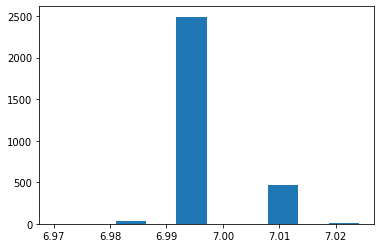

In [17]:
per =[]
for r in results_transit:
    per.append(r.period)
    
plt.hist(per)

Text(0.5, 1.0, 'True Distribution')

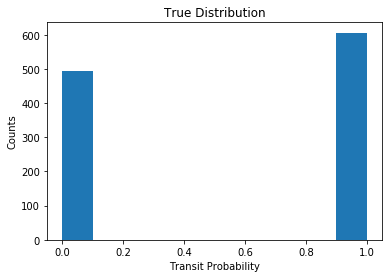

In [18]:
plt.hist(y_test)
plt.ylabel('Counts')
plt.xlabel('Transit Probability')
plt.title("True Distribution")

In [19]:
y_test[0]

1

In [20]:
model.predict(x_test[0:1])

array([[0.54422164]], dtype=float32)

In [21]:
y_pred = model.predict(x_test)[:,0]
true_pos = 0 
false_pos = 0
true_neg = 0 
false_neg = 0

thresh = 0.5
for i, y in enumerate(y_pred):
    if (y_test[i] == 1):
        if (y>thresh):
            true_pos += 1
        else:
            false_neg += 1
    else:
        if (y>thresh):
            false_pos += 1
        else:
            true_neg += 1
print('True Positives: ' + str(true_pos)) 
print('True Negatives: ' + str(true_neg)) 
print('False Positives: ' + str(false_pos)) 
print('False Negative: ' + str(false_neg)) 

True Positives: 606
True Negatives: 0
False Positives: 494
False Negative: 0


In [22]:
# Unweighted
"""True Positives: 172
True Negatives: 703
False Positives: 54
False Negative: 151"""

'True Positives: 172\nTrue Negatives: 703\nFalse Positives: 54\nFalse Negative: 151'

In [23]:
def log_likelihood(f, probab):
    likelihood_each_star = np.log(f*prob + (1-f)*(1-prob))
    return np.nansum(likelihood_each_star)

In [24]:
f = np.linspace(0.01,.99,99)

# Create empty array to save probabilties for each f value
log_Likelihood_arr = np.zeros(len(f))

# Now test out each value of f in the likelihood, populating the log_Likelihood_arr with probabilities
for i in range(len(f)):
    print(i)
    log_Likelihood_arr[i] = log_likelihood(f[i],prob)#,max_per,pt,pn)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


Best fit f = 0.99 , true value = 0.5509090909090909


Text(0.5, 1.0, 'Likelihood for 1.5R, 100 ppm')

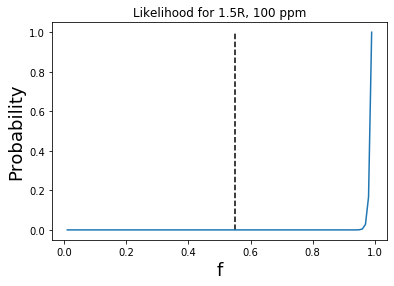

In [33]:
probabilities  = np.exp(log_Likelihood_arr-np.max(log_Likelihood_arr))

# what is the f value corresponding to the peak?
print("Best fit f = " + str(f[np.argmax(probabilities)]), ", true value = " + str(len(np.nonzero(y_test)[0])/len(y_test)))

# Plot the probabilities
plt.plot(f,probabilities)
plt.xlabel("f",fontsize=18)
plt.ylabel("Probability",fontsize=18)
plt.vlines(len(np.nonzero(y_test)[0])/len(y_test),0,1,linestyle='dashed')
plt.title('Likelihood for 1.5R, 100 ppm')

In [26]:
len(np.nonzero(y_test)[0])

606